# PPMI Gait Analysis
This data set is part of the Parkinson's Progression Markers Initiative. Anat Mirelman, PhD, of Tel Aviv University is the PI. According to the study summary: "The Gait study was proposed in order to obtain quantitative, objective motor measures that could inform on pre-clinical symptoms, progression markers, and dynamic changes of function throughout disease and potential modifiers and mediators of motor symptoms."

Your goal is to examine the data and later implement some ML algorithms to try and classify PD patients from non-PD patients based on the gait measures.

To learn more about PPMI, go here: http://www.ppmi-info.org/  
To learn more about working with the data, go here: www.ppmi-info.org/wp-content/uploads/2015/12/PPMI-data-access-final.mp4


In [23]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# seaborn is for making figures look really nice
import seaborn as sns

# this is a big hint for a later part of the exercise
from datetime import datetime 
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
import warnings
warnings.simplefilter('ignore')


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc

import plotly.express as px
import ipyvolume as ipv

import pylab



First, you need to import the necessary data sets. The gait data are the objective gait measures. The screening data contain information on all of the individuals participating in PPMI.  

In [3]:
# read in csv files as pandas data frames
gait_variables=pd.read_csv('Gait_Data___Arm_swing.csv')
Screening_variables=pd.read_csv('Screening___Demographics.csv',usecols=['PATNO','APPRDX','CURRENT_APPRDX','BIRTHDT','GENDER','ORIG_ENTRY','LAST_UPDATE'])


# take a look at the variables in each csv


The reason why we have to read in both csv files is because the gait csv does not contain all of the necessary information we want about the subjects. For instance, we don't know from the gait data what diagnosis each individual has received. This is a problem if we later want to classify PD vs non-PD. The diagnosis information is contained within the screening csv. The trick is that there are a lot of subjects in the screening csv that were not part of the gait study. ***What to do?***

My advice is to:  
1) Get rid of the variables from the screening csv that we don't want or need.   
2) Merge the two data frames into one that has both gait and screening data for all of the subjects in the gait study.

**Hint:** Every individual in PPMI has a unique ID that is contained in 'PATNO'. The diagnosis each subject initially received is in 'APPRDX' and their most current diagnosis i in 'CURRENT_APPRDX'.

From screening data, we only care about a few variables.

In [4]:
# Probably want to keep 'PATNO', 'APPRDX', 'CURRENT_APPRDX', 'BIRTHDT', 'GENDER', 'ORIG_ENTRY', 'LAST_UPDATE'
# Now create new dataframe that only includes patients common to both gait and screen

gait=pd.merge(gait_variables, Screening_variables, how='inner', on=['PATNO'])

# Some subjects were tested on multiple visits. How many unique subjects are there? 103
#To ensure that common screening data has all the unique patients
gait_unique=np.unique(gait_variables['PATNO'])


print (len(gait_unique))


# merging data:
#gait_screening_variables=gait_variables.merge(Common_Screeningdata)

gait=gait.drop(columns=['CURRENT_APPRDX', 'EVENT_ID', 'COHORT'])


103


Check to see if any subjects changed diagnoses within the course of the study. If so, drop one of the diagnosis columns. 

It also makes sense to subset the data so that you can look at data only from each subjects' initial visit. How are you going to do this? **Hint:** You will need to reformat the dates so that they are in a format that python/pandas will understand as datetime. **Extra hint:** You will probably want to use the datetime.strptime function.

In [5]:
# We first need to format the dates correctly. 
for i in range (0, len(gait)):
    #INFODT
    infodtstr=gait.INFODT[i]
    infodt=datetime.strptime(infodtstr,'%m/%Y')
    
   

    #ORIG_ENTRY
    origstr=gait.ORIG_ENTRY[i]
    orig_entry=datetime.strptime(origstr,'%m/%Y')
    
    gait.INFODT[i]=infodt
    gait.ORIG_ENTRY[i]=orig_entry
   
# Next we want to create new data frame with only first visit's data

data = gait.sort_values('INFODT').groupby(['PATNO'], as_index=False).first()
data = data.reset_index()
del data['index']

data 
    

    



PATNO               INFODT   SP_U   RA_AMP_U   LA_AMP_U  RA_STD_U  \
0    40553  2017-05-01 00:00:00  0.806  36.126752  17.767148  4.386049   
1    40555  2017-06-01 00:00:00  1.000   3.700673  24.505864  1.345954   
2    40562  2019-05-01 00:00:00    NaN  22.848971  26.057444  3.932167   
3    40567  2019-02-01 00:00:00  0.973  29.782323  41.685751  9.155024   
4    40578  2017-12-01 00:00:00  1.104  35.037770  30.911425  4.972681   
..     ...                  ...    ...        ...        ...       ...   
98   60057  2019-04-01 00:00:00    NaN  29.782323  41.685751  9.155024   
99   60059  2019-05-01 00:00:00    NaN  31.132878  33.728352  8.217441   
100  60060  2019-04-01 00:00:00    NaN  16.501651  10.129571  2.696206   
101  60118  2019-03-01 00:00:00  1.196  24.068546  20.238848  2.467939   
102  60148  2019-03-01 00:00:00  1.120        NaN        NaN       NaN   

      LA_STD_U     SYM_U  R_JERK_U  L_JERK_U  ...  TUG2_STEP_NUM  \
0     2.648999  1.144444  0.023956  0.090631  ...      13.097656   
1     2.865374  0.847282  0.016979  0.020427  ...      14.117188   
2     4.647285  0.144820  0.226004  0.061215  ...       6.890625   
3    18.263038  0.811041  0.045715  0.098497  ...       9.140625   
4     5.745657  0.134001  0.026055  0.047951  ...      12.363281   
..         ...       ...       ...       ...  ...            ...   
98   18.263038  0.811041  0.045715  0.098497  ...       9.356445   
99    3.558946  0.172383  0.046673  0.054011  ...      10.600586   
100   3.546745  0.723158  0.011081  0.006234  ...            NaN   
101   3.091471  0.199895  0.024963  0.010609  ...       9.529297   
102        NaN       NaN       NaN       NaN  ...       9.468750   

     TUG2_STRAIGHT_DUR  TUG2_TURNS_DUR  TUG2_STEP_REG  TUG2_STEP_SYM  APPRDX  \
0             0.539062        1.539062       0.642412       1.046546     5.0   
1             0.609375        1.507812       0.442304       0.821767     5.0   
2             0.460938        1.269531       0.435900       0.698603     8.0   
3             0.585938        1.714844       0.636833       1.788158     6.0   
4             0.570312        1.632812       0.552915       1.465661     5.0   
..                 ...             ...            ...            ...     ...   
98            0.585938        1.714844       0.638727       1.743030     4.0   
99            0.570312        1.917969       0.532902       1.168936     4.0   
100                NaN             NaN            NaN            NaN     4.0   
101           0.585938        1.703125       0.469711       0.957126     4.0   
102           0.664062        1.453125       0.526204       0.712115     4.0   

     BIRTHDT  GENDER  ORIG_ENTRY            LAST_UPDATE  
0     1945.0     1.0  2014-04-01  2014-04-10 05:08:31.0  
1     1957.0     1.0  2014-05-01  2014-05-29 02:19:55.0  
2     1983.0     2.0  2014-03-01  2014-03-06 00:13:01.0  
3     1966.0     2.0  2019-01-01  2019-02-12 06:02:58.0  
4     1963.0     2.0  2014-10-01  2014-10-06 07:07:22.0  
..       ...     ...         ...                    ...  
98    1953.0     2.0  2014-02-01  2014-03-20 09:46:40.0  
99    1943.0     2.0  2014-02-01  2014-04-01 11:02:26.0  
100   1948.0     1.0  2014-02-01  2014-04-02 08:39:39.0  
101   1956.0     2.0  2014-11-01  2015-02-24 00:56:12.0  
102   1948.0     2.0  2015-02-01  2015-02-03 07:17:55.0  

[103 rows x 63 columns]

It might be a good idea to print out a csv of the baseline data at this point.

In [6]:
data.to_csv('Modified_Gait_ScreeningData2.csv', index = False)

All right. At this piont, you can probably appreciate that data wrangling isn't easy. But now that we have a slice of the data that we're interested in, let's start to look at the data. 

In [7]:
# df.info() and df.columns are a good place to start -- you should probably have used them earlier, too
data.info()
data.columns



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 63 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   PATNO              103 non-null    int64         
 1   INFODT             103 non-null    object        
 2   SP_U               94 non-null     float64       
 3   RA_AMP_U           94 non-null     float64       
 4   LA_AMP_U           94 non-null     float64       
 5   RA_STD_U           94 non-null     float64       
 6   LA_STD_U           94 non-null     float64       
 7   SYM_U              94 non-null     float64       
 8   R_JERK_U           94 non-null     float64       
 9   L_JERK_U           94 non-null     float64       
 10  ASA_U              94 non-null     float64       
 11  ASYM_IND_U         94 non-null     float64       
 12  TRA_U              94 non-null     float64       
 13  T_AMP_U            94 non-null     float64       
 14  CAD_U     

Index(['PATNO', 'INFODT', 'SP_U', 'RA_AMP_U', 'LA_AMP_U', 'RA_STD_U',
       'LA_STD_U', 'SYM_U', 'R_JERK_U', 'L_JERK_U', 'ASA_U', 'ASYM_IND_U',
       'TRA_U', 'T_AMP_U', 'CAD_U', 'STR_T_U', 'STR_CV_U', 'STEP_REG_U',
       'STEP_SYM_U', 'JERK_T_U', 'SP__DT', 'RA_AMP_DT', 'LA_AMP_DT',
       'RA_STD_DT', 'LA_STD_DT', 'SYM_DT', 'R_JERK_DT', 'L_JERK_DT', 'ASA_DT',
       'ASYM_IND_DT', 'TRA_DT', 'T_AMP_DT', 'CAD_DT', 'STR_T_DT', 'STR_CV_DT',
       'STEP_REG_DT', 'STEP_SYM_DT', 'JERK_T_DT', 'SW_VEL_OP', 'SW_PATH_OP',
       'SW_FREQ_OP', 'SW_JERK_OP', 'SW_VEL_CL', 'SW_PATH_CL', 'SW_FREQ_CL',
       'SW_JERK_CL', 'TUG1_DUR', 'TUG1_STEP_NUM', 'TUG1_STRAIGHT_DUR',
       'TUG1_TURNS_DUR', 'TUG1_STEP_REG', 'TUG1_STEP_SYM', 'TUG2_DUR',
       'TUG2_STEP_NUM', 'TUG2_STRAIGHT_DUR', 'TUG2_TURNS_DUR', 'TUG2_STEP_REG',
       'TUG2_STEP_SYM', 'APPRDX', 'BIRTHDT', 'GENDER', 'ORIG_ENTRY',
       'LAST_UPDATE'],
      dtype='object')

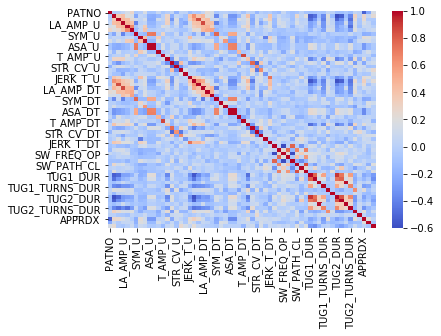

In [8]:
# Given the large number of predictors, you might want to start looking for correlations among the data. 
# Try plotting a correlation matrix using a seaborn function. 

data.corr()
sns.heatmap(data.corr(),cmap='coolwarm' )





In [9]:
data.groupby('APPRDX').count()

PATNO  INFODT  SP_U  RA_AMP_U  LA_AMP_U  RA_STD_U  LA_STD_U  SYM_U  \
APPRDX                                                                       
4.0         7       7     2         6         6         6         6      6   
5.0        53      53    52        49        49        49        49     49   
6.0        42      42    40        38        38        38        38     38   
8.0         1       1     0         1         1         1         1      1   

        R_JERK_U  L_JERK_U  ...  TUG2_DUR  TUG2_STEP_NUM  TUG2_STRAIGHT_DUR  \
APPRDX                      ...                                               
4.0            6         6  ...         5              5                  5   
5.0           49        49  ...        52             52                 52   
6.0           38        38  ...        40             40                 40   
8.0            1         1  ...         1              1                  1   

        TUG2_TURNS_DUR  TUG2_STEP_REG  TUG2_STEP_SYM  BIRTHDT  GENDER  \
APPRDX                                                                  
4.0                  5              5              5        7       7   
5.0                 52             52             52       53      53   
6.0                 40             40             40       42      42   
8.0                  1              1              1        1       1   

        ORIG_ENTRY  LAST_UPDATE  
APPRDX                           
4.0              7            7  
5.0             53           53  
6.0             42           42  
8.0              1            1  

[4 rows x 62 columns]

In [8]:
# count number of 'patients with each diagnosis
data.groupby('APPRDX').count()

# Count how many subjects have missing data
a=sum([True for idx,row in data.iterrows() if any(row.isnull())])
print(a)

        
# Create new data frame that excludes subjects with missing data
data2=data.dropna()
data2 = data2.reset_index()
del data2['index']


# Now how many subjects are there per group?
data2.groupby('APPRDX').count()

data2

26


PATNO               INFODT   SP_U   RA_AMP_U   LA_AMP_U  RA_STD_U  \
0   40553  2017-05-01 00:00:00  0.806  36.126752  17.767148  4.386049   
1   40555  2017-06-01 00:00:00  1.000   3.700673  24.505864  1.345954   
2   40567  2019-02-01 00:00:00  0.973  29.782323  41.685751  9.155024   
3   40578  2017-12-01 00:00:00  1.104  35.037770  30.911425  4.972681   
4   40585  2017-06-01 00:00:00  1.305  38.543712  21.629526  4.982411   
..    ...                  ...    ...        ...        ...       ...   
72  42451  2016-12-01 00:00:00  1.333  30.460233  70.541678  6.811038   
73  42452  2016-12-01 00:00:00  1.271  16.311517  40.832855  6.109233   
74  42453  2016-12-01 00:00:00  0.982   2.764410  25.210230  1.611778   
75  42456  2017-02-01 00:00:00  1.307  40.041035  32.668807  3.980181   
76  60118  2019-03-01 00:00:00  1.196  24.068546  20.238848  2.467939   

     LA_STD_U     SYM_U  R_JERK_U  L_JERK_U  ...  TUG2_STEP_NUM  \
0    2.648999  1.144444  0.023956  0.090631  ...      13.097656   
1    2.865374  0.847282  0.016979  0.020427  ...      14.117188   
2   18.263038  0.811041  0.045715  0.098497  ...       9.140625   
3    5.745657  0.134001  0.026055  0.047951  ...      12.363281   
4    5.998333  0.805728  0.041232  0.019728  ...      13.681641   
..        ...       ...       ...       ...  ...            ...   
72  13.168107  0.558768  0.010897  0.004974  ...       6.589844   
73   4.708778  0.596745  0.002103  0.001666  ...       5.712891   
74   3.438281  0.890630  0.008972  0.001199  ...      18.304688   
75   4.627993  0.237751  0.007926  0.016191  ...       7.314453   
76   3.091471  0.199895  0.024963  0.010609  ...       9.529297   

    TUG2_STRAIGHT_DUR  TUG2_TURNS_DUR  TUG2_STEP_REG  TUG2_STEP_SYM  APPRDX  \
0            0.539062        1.539062       0.642412       1.046546     5.0   
1            0.609375        1.507812       0.442304       0.821767     5.0   
2            0.585938        1.714844       0.636833       1.788158     6.0   
3            0.570312        1.632812       0.552915       1.465661     5.0   
4            0.500000        2.210938       0.308428       0.782646     5.0   
..                ...             ...            ...            ...     ...   
72           0.523438        1.613281       0.592706       1.036322     5.0   
73           0.617188        1.718750       0.491318       1.121519     5.0   
74           0.687500        3.492188       0.507125       0.966052     5.0   
75           0.570312        1.859375       0.766691       1.007728     5.0   
76           0.585938        1.703125       0.469711       0.957126     4.0   

    BIRTHDT  GENDER  ORIG_ENTRY            LAST_UPDATE  
0    1945.0     1.0  2014-04-01  2014-04-10 05:08:31.0  
1    1957.0     1.0  2014-05-01  2014-05-29 02:19:55.0  
2    1966.0     2.0  2019-01-01  2019-02-12 06:02:58.0  
3    1963.0     2.0  2014-10-01  2014-10-06 07:07:22.0  
4    1962.0     2.0  2014-04-01  2014-05-29 02:12:32.0  
..      ...     ...         ...                    ...  
72   1947.0     1.0  2017-02-01  2017-02-01 00:14:02.0  
73   1954.0     2.0  2017-01-01  2017-01-29 02:46:23.0  
74   1948.0     1.0  2017-01-01  2017-01-31 00:04:01.0  
75   1950.0     2.0  2017-03-01  2017-03-13 23:54:10.0  
76   1956.0     2.0  2014-11-01  2015-02-24 00:56:12.0  

[77 rows x 63 columns]

According to the presentation on accessing PPMI data ("08b_v2_Caspell_Foster_PPMI-Data-Access_May-2015-v2.0.pdf"), the APPRDX codes in our data set correspond to:

**4 - Prodromal (this means an individual who appears at risk for PD based on report of "anosmia" or disrupted REM behavior)**

**5 - Genetic Cohort subject with PD**

**6 - Genetic Cohort subject unaffected**

In [9]:
# Based on above diagnoses, we want to classify subjects as either having PD (APPRDX = 5) or no PD (APPRDX = 4 or 6)
# Create a new column called PD. For each subject, PD takes a value of 1 for those with PD and 0 for those without.
data2['CLASSIFY'] = [0 if x ==4|6 else 1 for x in data2['APPRDX']]

data2

PATNO               INFODT   SP_U   RA_AMP_U   LA_AMP_U  RA_STD_U  \
0   40553  2017-05-01 00:00:00  0.806  36.126752  17.767148  4.386049   
1   40555  2017-06-01 00:00:00  1.000   3.700673  24.505864  1.345954   
2   40567  2019-02-01 00:00:00  0.973  29.782323  41.685751  9.155024   
3   40578  2017-12-01 00:00:00  1.104  35.037770  30.911425  4.972681   
4   40585  2017-06-01 00:00:00  1.305  38.543712  21.629526  4.982411   
..    ...                  ...    ...        ...        ...       ...   
72  42451  2016-12-01 00:00:00  1.333  30.460233  70.541678  6.811038   
73  42452  2016-12-01 00:00:00  1.271  16.311517  40.832855  6.109233   
74  42453  2016-12-01 00:00:00  0.982   2.764410  25.210230  1.611778   
75  42456  2017-02-01 00:00:00  1.307  40.041035  32.668807  3.980181   
76  60118  2019-03-01 00:00:00  1.196  24.068546  20.238848  2.467939   

     LA_STD_U     SYM_U  R_JERK_U  L_JERK_U  ...  TUG2_STRAIGHT_DUR  \
0    2.648999  1.144444  0.023956  0.090631  ...           0.539062   
1    2.865374  0.847282  0.016979  0.020427  ...           0.609375   
2   18.263038  0.811041  0.045715  0.098497  ...           0.585938   
3    5.745657  0.134001  0.026055  0.047951  ...           0.570312   
4    5.998333  0.805728  0.041232  0.019728  ...           0.500000   
..        ...       ...       ...       ...  ...                ...   
72  13.168107  0.558768  0.010897  0.004974  ...           0.523438   
73   4.708778  0.596745  0.002103  0.001666  ...           0.617188   
74   3.438281  0.890630  0.008972  0.001199  ...           0.687500   
75   4.627993  0.237751  0.007926  0.016191  ...           0.570312   
76   3.091471  0.199895  0.024963  0.010609  ...           0.585938   

    TUG2_TURNS_DUR  TUG2_STEP_REG  TUG2_STEP_SYM  APPRDX  BIRTHDT  GENDER  \
0         1.539062       0.642412       1.046546     5.0   1945.0     1.0   
1         1.507812       0.442304       0.821767     5.0   1957.0     1.0   
2         1.714844       0.636833       1.788158     6.0   1966.0     2.0   
3         1.632812       0.552915       1.465661     5.0   1963.0     2.0   
4         2.210938       0.308428       0.782646     5.0   1962.0     2.0   
..             ...            ...            ...     ...      ...     ...   
72        1.613281       0.592706       1.036322     5.0   1947.0     1.0   
73        1.718750       0.491318       1.121519     5.0   1954.0     2.0   
74        3.492188       0.507125       0.966052     5.0   1948.0     1.0   
75        1.859375       0.766691       1.007728     5.0   1950.0     2.0   
76        1.703125       0.469711       0.957126     4.0   1956.0     2.0   

    ORIG_ENTRY            LAST_UPDATE  CLASSIFY  
0   2014-04-01  2014-04-10 05:08:31.0         1  
1   2014-05-01  2014-05-29 02:19:55.0         1  
2   2019-01-01  2019-02-12 06:02:58.0         0  
3   2014-10-01  2014-10-06 07:07:22.0         1  
4   2014-04-01  2014-05-29 02:12:32.0         1  
..         ...                    ...       ...  
72  2017-02-01  2017-02-01 00:14:02.0         1  
73  2017-01-01  2017-01-29 02:46:23.0         1  
74  2017-01-01  2017-01-31 00:04:01.0         1  
75  2017-03-01  2017-03-13 23:54:10.0         1  
76  2014-11-01  2015-02-24 00:56:12.0         1  

[77 rows x 64 columns]

In [10]:
data2.columns
interest1=['TUG1_DUR', 'TUG1_STEP_NUM', 'TUG1_STRAIGHT_DUR',
       'TUG1_TURNS_DUR', 'TUG1_STEP_REG', 'TUG1_STEP_SYM']

interest2=['TUG2_DUR', 'TUG2_STEP_NUM', 'TUG2_STRAIGHT_DUR', 'TUG2_TURNS_DUR', 'TUG2_STEP_REG','TUG2_STEP_SYM']

interest3=['CAD_U', 'STR_T_U', 'STR_CV_U', 'STEP_REG_U','STEP_SYM_U','SP_U','JERK_T_U']
           
interest4=['SP__DT','CAD_DT','STEP_REG_DT', 'STEP_SYM_DT','STR_T_DT','STR_CV_DT','JERK_T_DT']

interest5=[ 'RA_AMP_U', 'LA_AMP_U', 'RA_STD_U','LA_STD_U', 'SYM_U', 'ASA_U', 'ASYM_IND_U','TRA_U','T_AMP_U','R_JERK_U', 'L_JERK_U']
       
interest6=['RA_AMP_DT', 'LA_AMP_DT', 'TRA_DT', 'T_AMP_DT', 'RA_STD_DT', 'LA_STD_DT','SYM_DT', 'R_JERK_DT', 'L_JERK_DT', 'ASA_DT','ASYM_IND_DT']

interest7=[ 'SW_VEL_OP', 'SW_PATH_OP','SW_FREQ_OP', 'SW_JERK_OP','SW_VEL_CL', 'SW_PATH_CL', 'SW_FREQ_CL', 'SW_JERK_CL']



<Figure size 720x720 with 0 Axes>

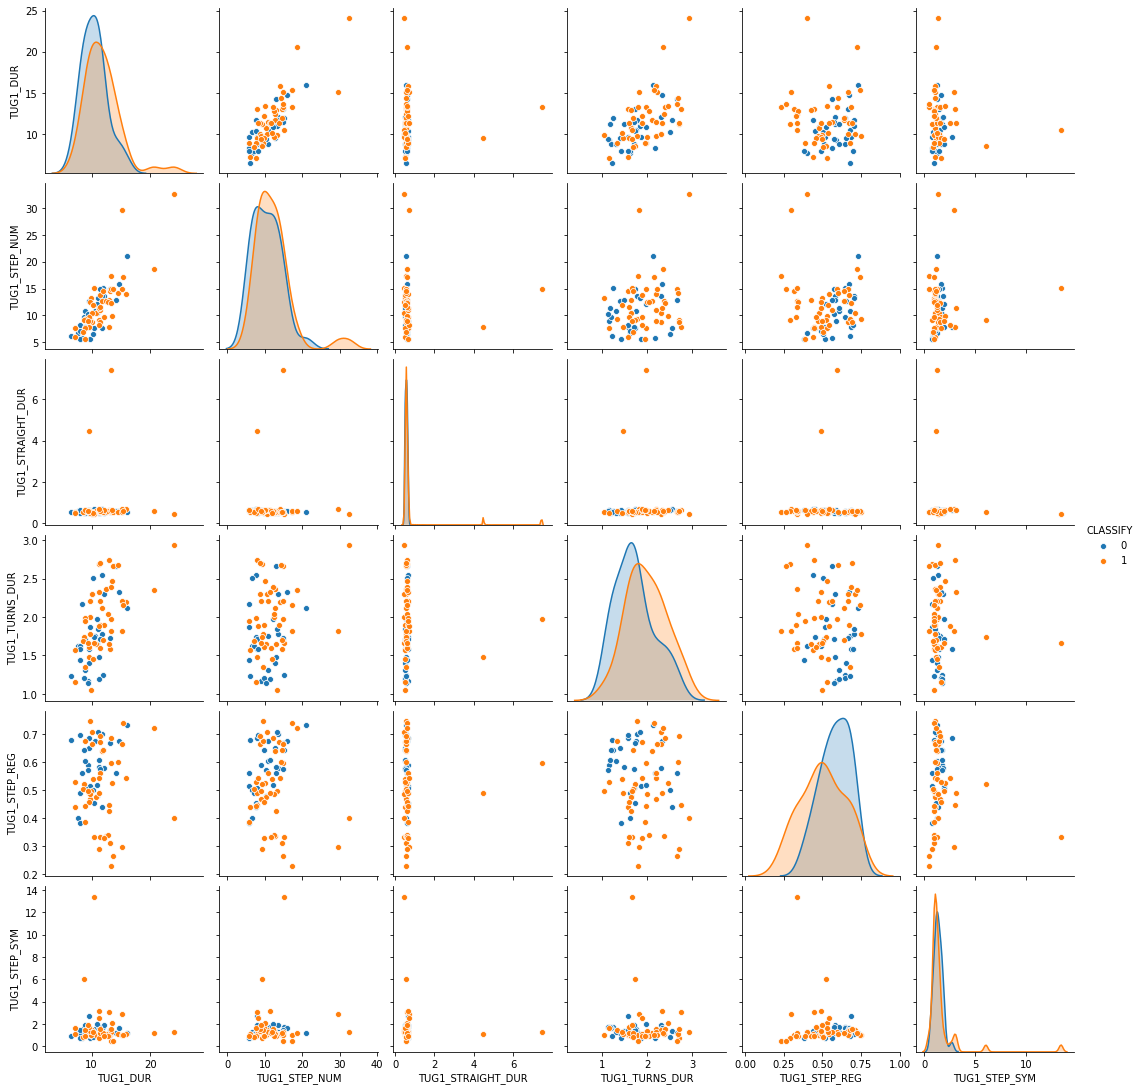

In [12]:
plt.figure(figsize=(10,10))
sns.pairplot(data2,vars=interest1,hue="CLASSIFY")

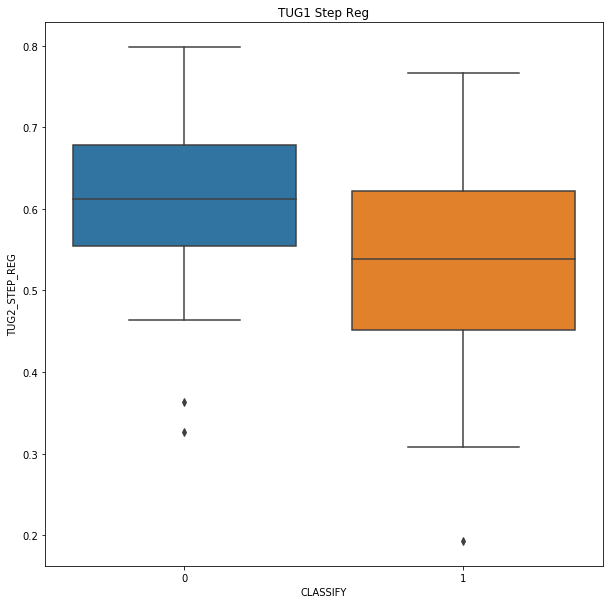

In [62]:
plt.figure(figsize = (10,10))
plt.title('TUG1 Step Reg')
sns.boxplot(x = 'CLASSIFY',y = 'TUG2_STEP_REG',data = data2)



<Figure size 720x720 with 0 Axes>

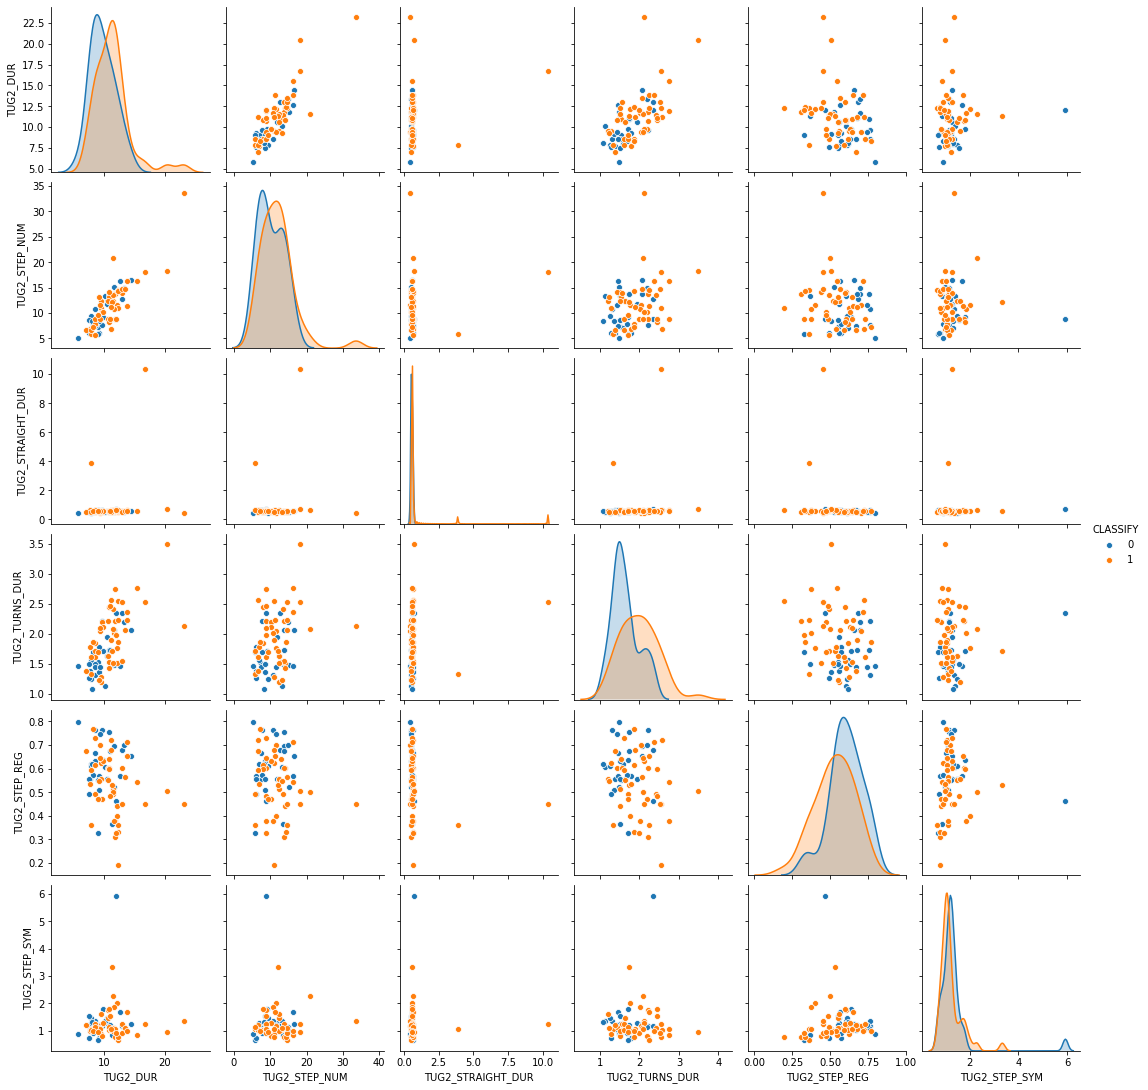

In [14]:
plt.figure(figsize=(10,10))
sns.pairplot(data2,vars=interest2,hue="CLASSIFY")

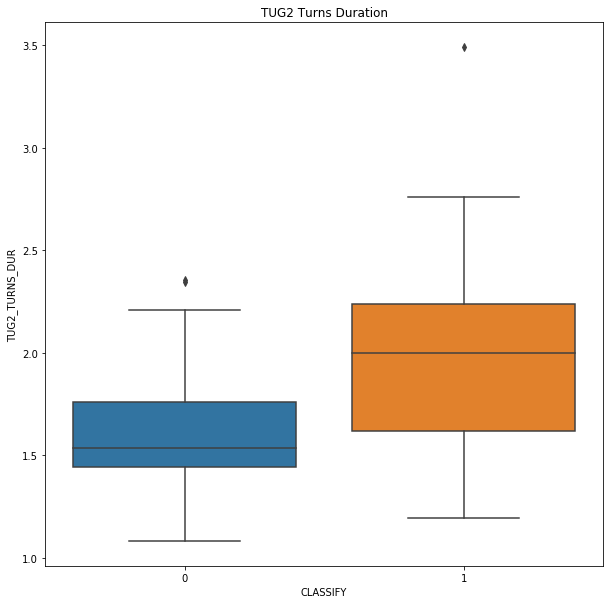

In [63]:
plt.figure(figsize = (10,10))
plt.title('TUG2 Turns Duration')
sns.boxplot(x = 'CLASSIFY',y = 'TUG2_TURNS_DUR',data = data2)

<Figure size 720x720 with 0 Axes>

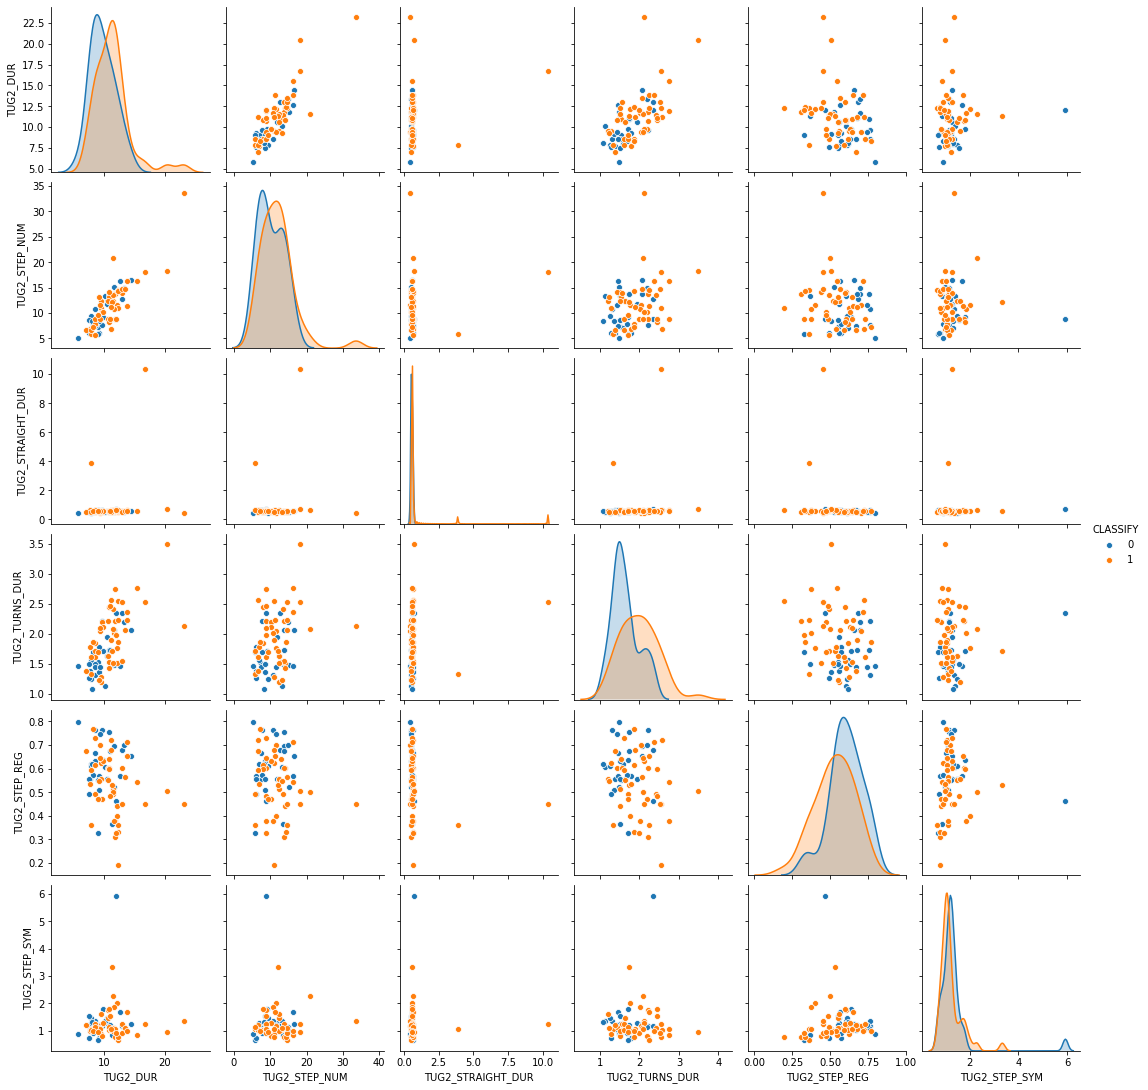

In [13]:
plt.figure(figsize=(10,10))
sns.pairplot(data2,vars=interest2,hue="CLASSIFY")

<Figure size 720x720 with 0 Axes>

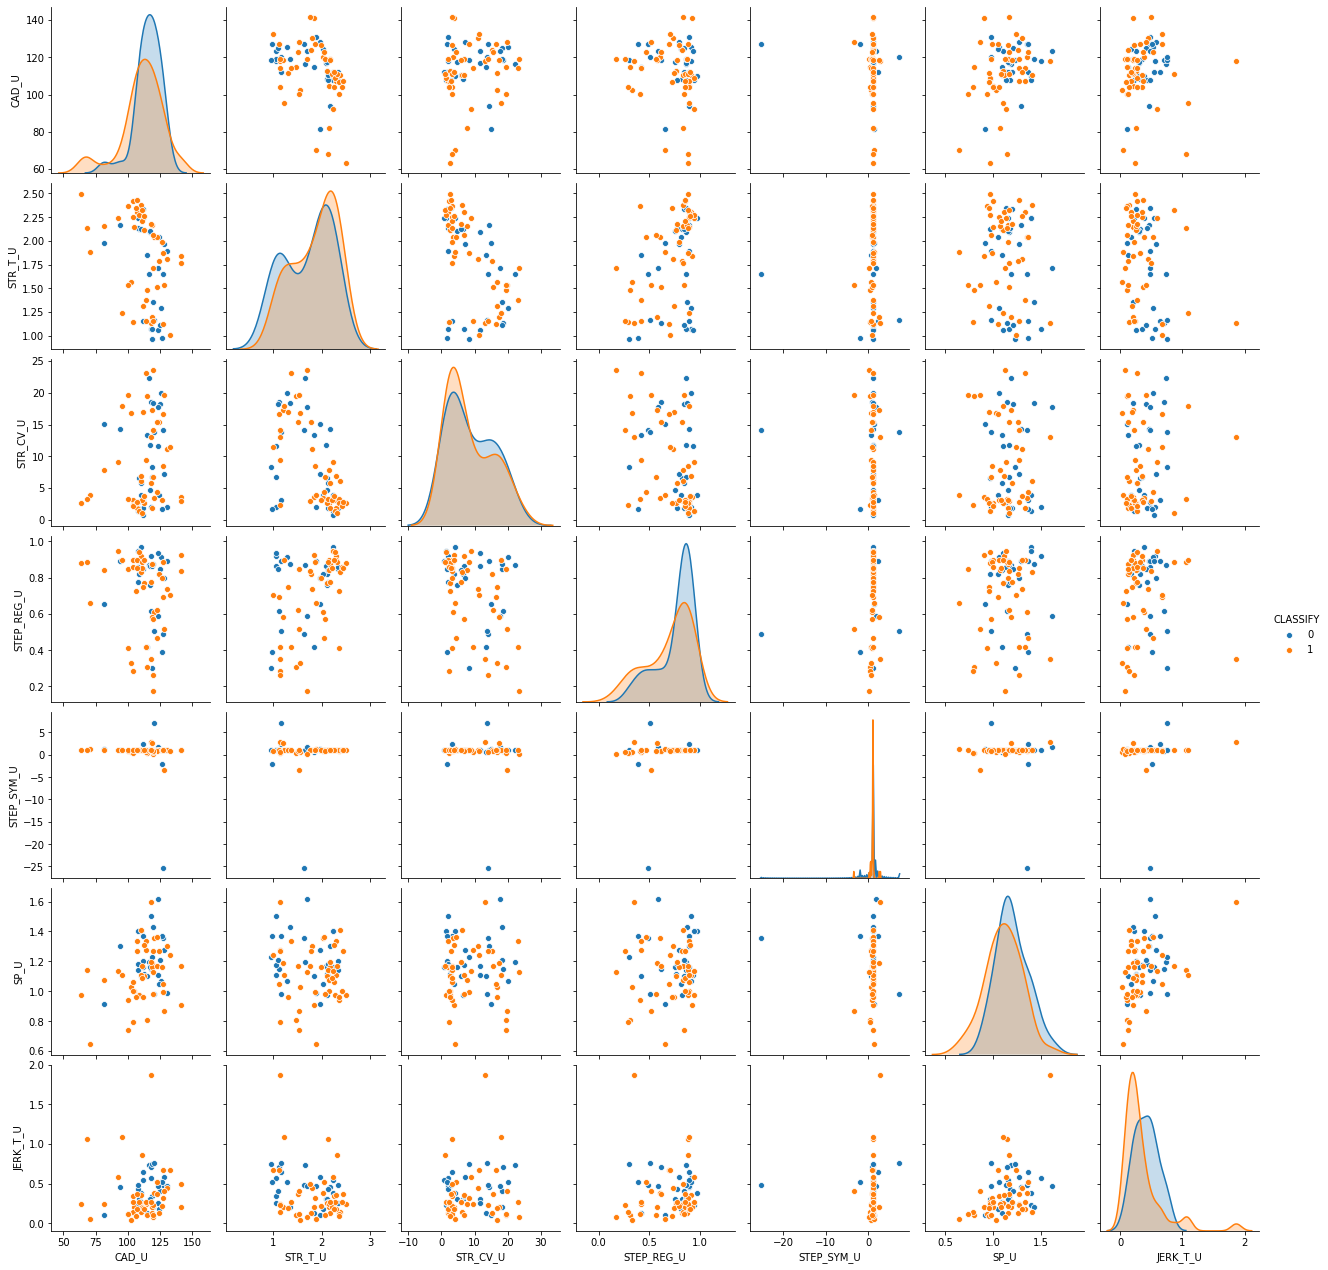

In [14]:
plt.figure(figsize=(10,10))
sns.pairplot(data2,vars=interest3,hue="CLASSIFY")


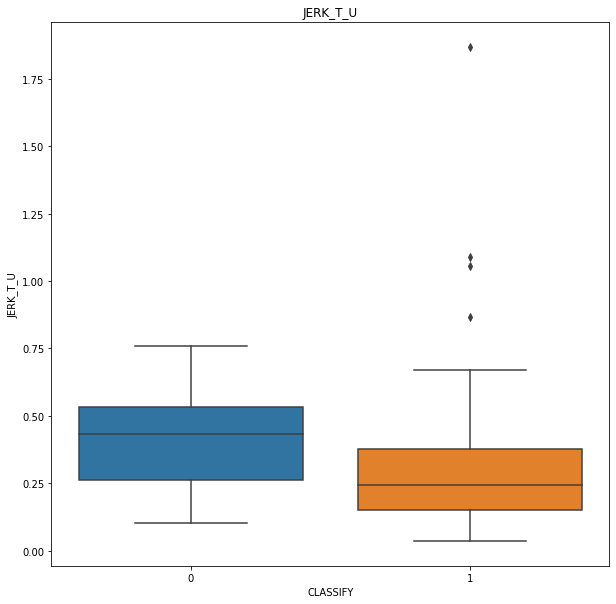

In [64]:
plt.figure(figsize = (10,10))
plt.title('JERK_T_U')
sns.boxplot(x = 'CLASSIFY',y = 'JERK_T_U',data = data2)

<Figure size 720x720 with 0 Axes>

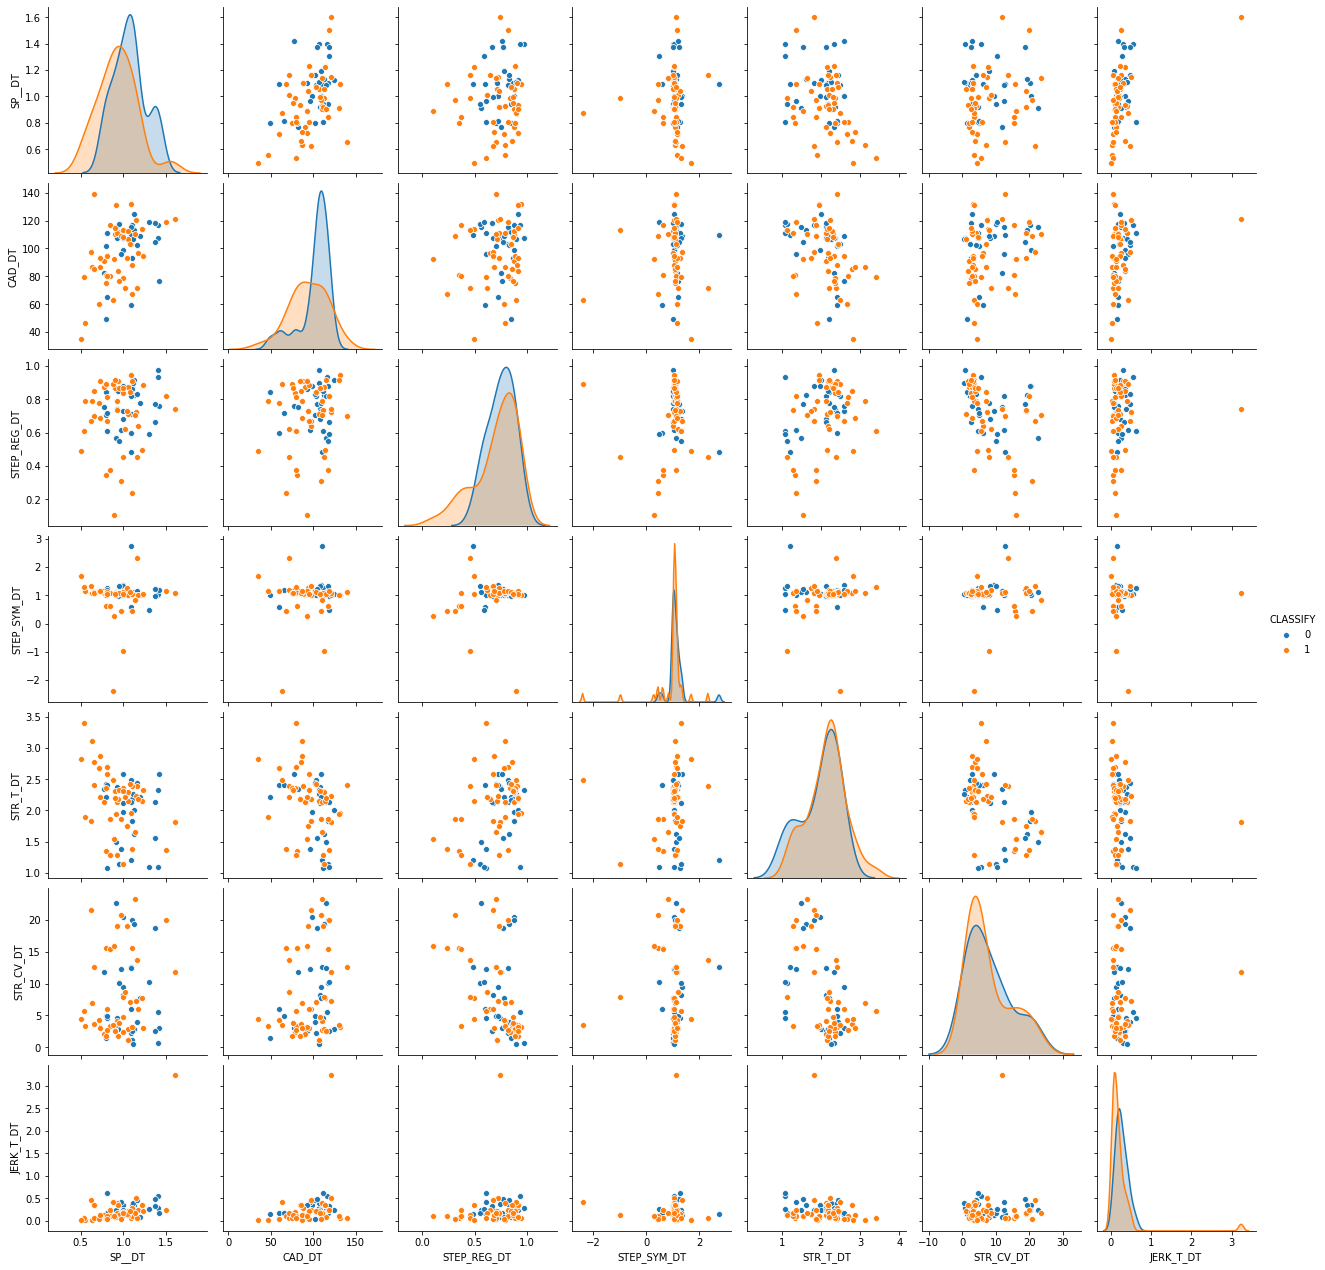

In [22]:
plt.figure(figsize=(10,10))
sns.pairplot(data2,vars=interest4,hue="CLASSIFY")

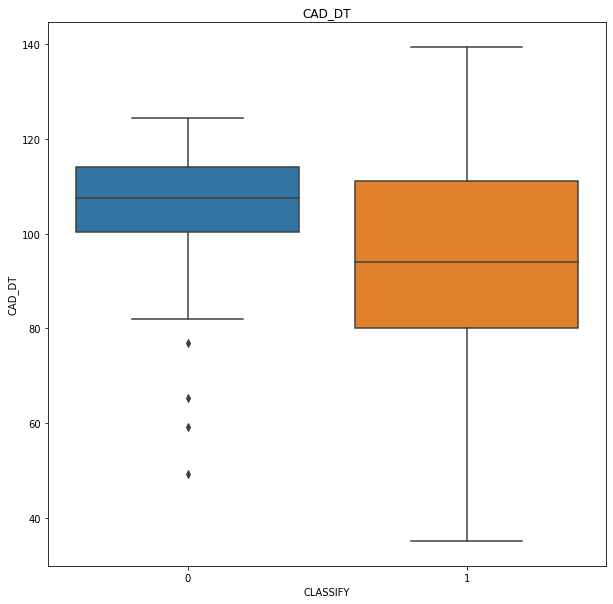

In [65]:
plt.figure(figsize = (10,10))
plt.title('CAD_DT')
sns.boxplot(x = 'CLASSIFY',y = 'CAD_DT',data = data2)

<Figure size 720x720 with 0 Axes>

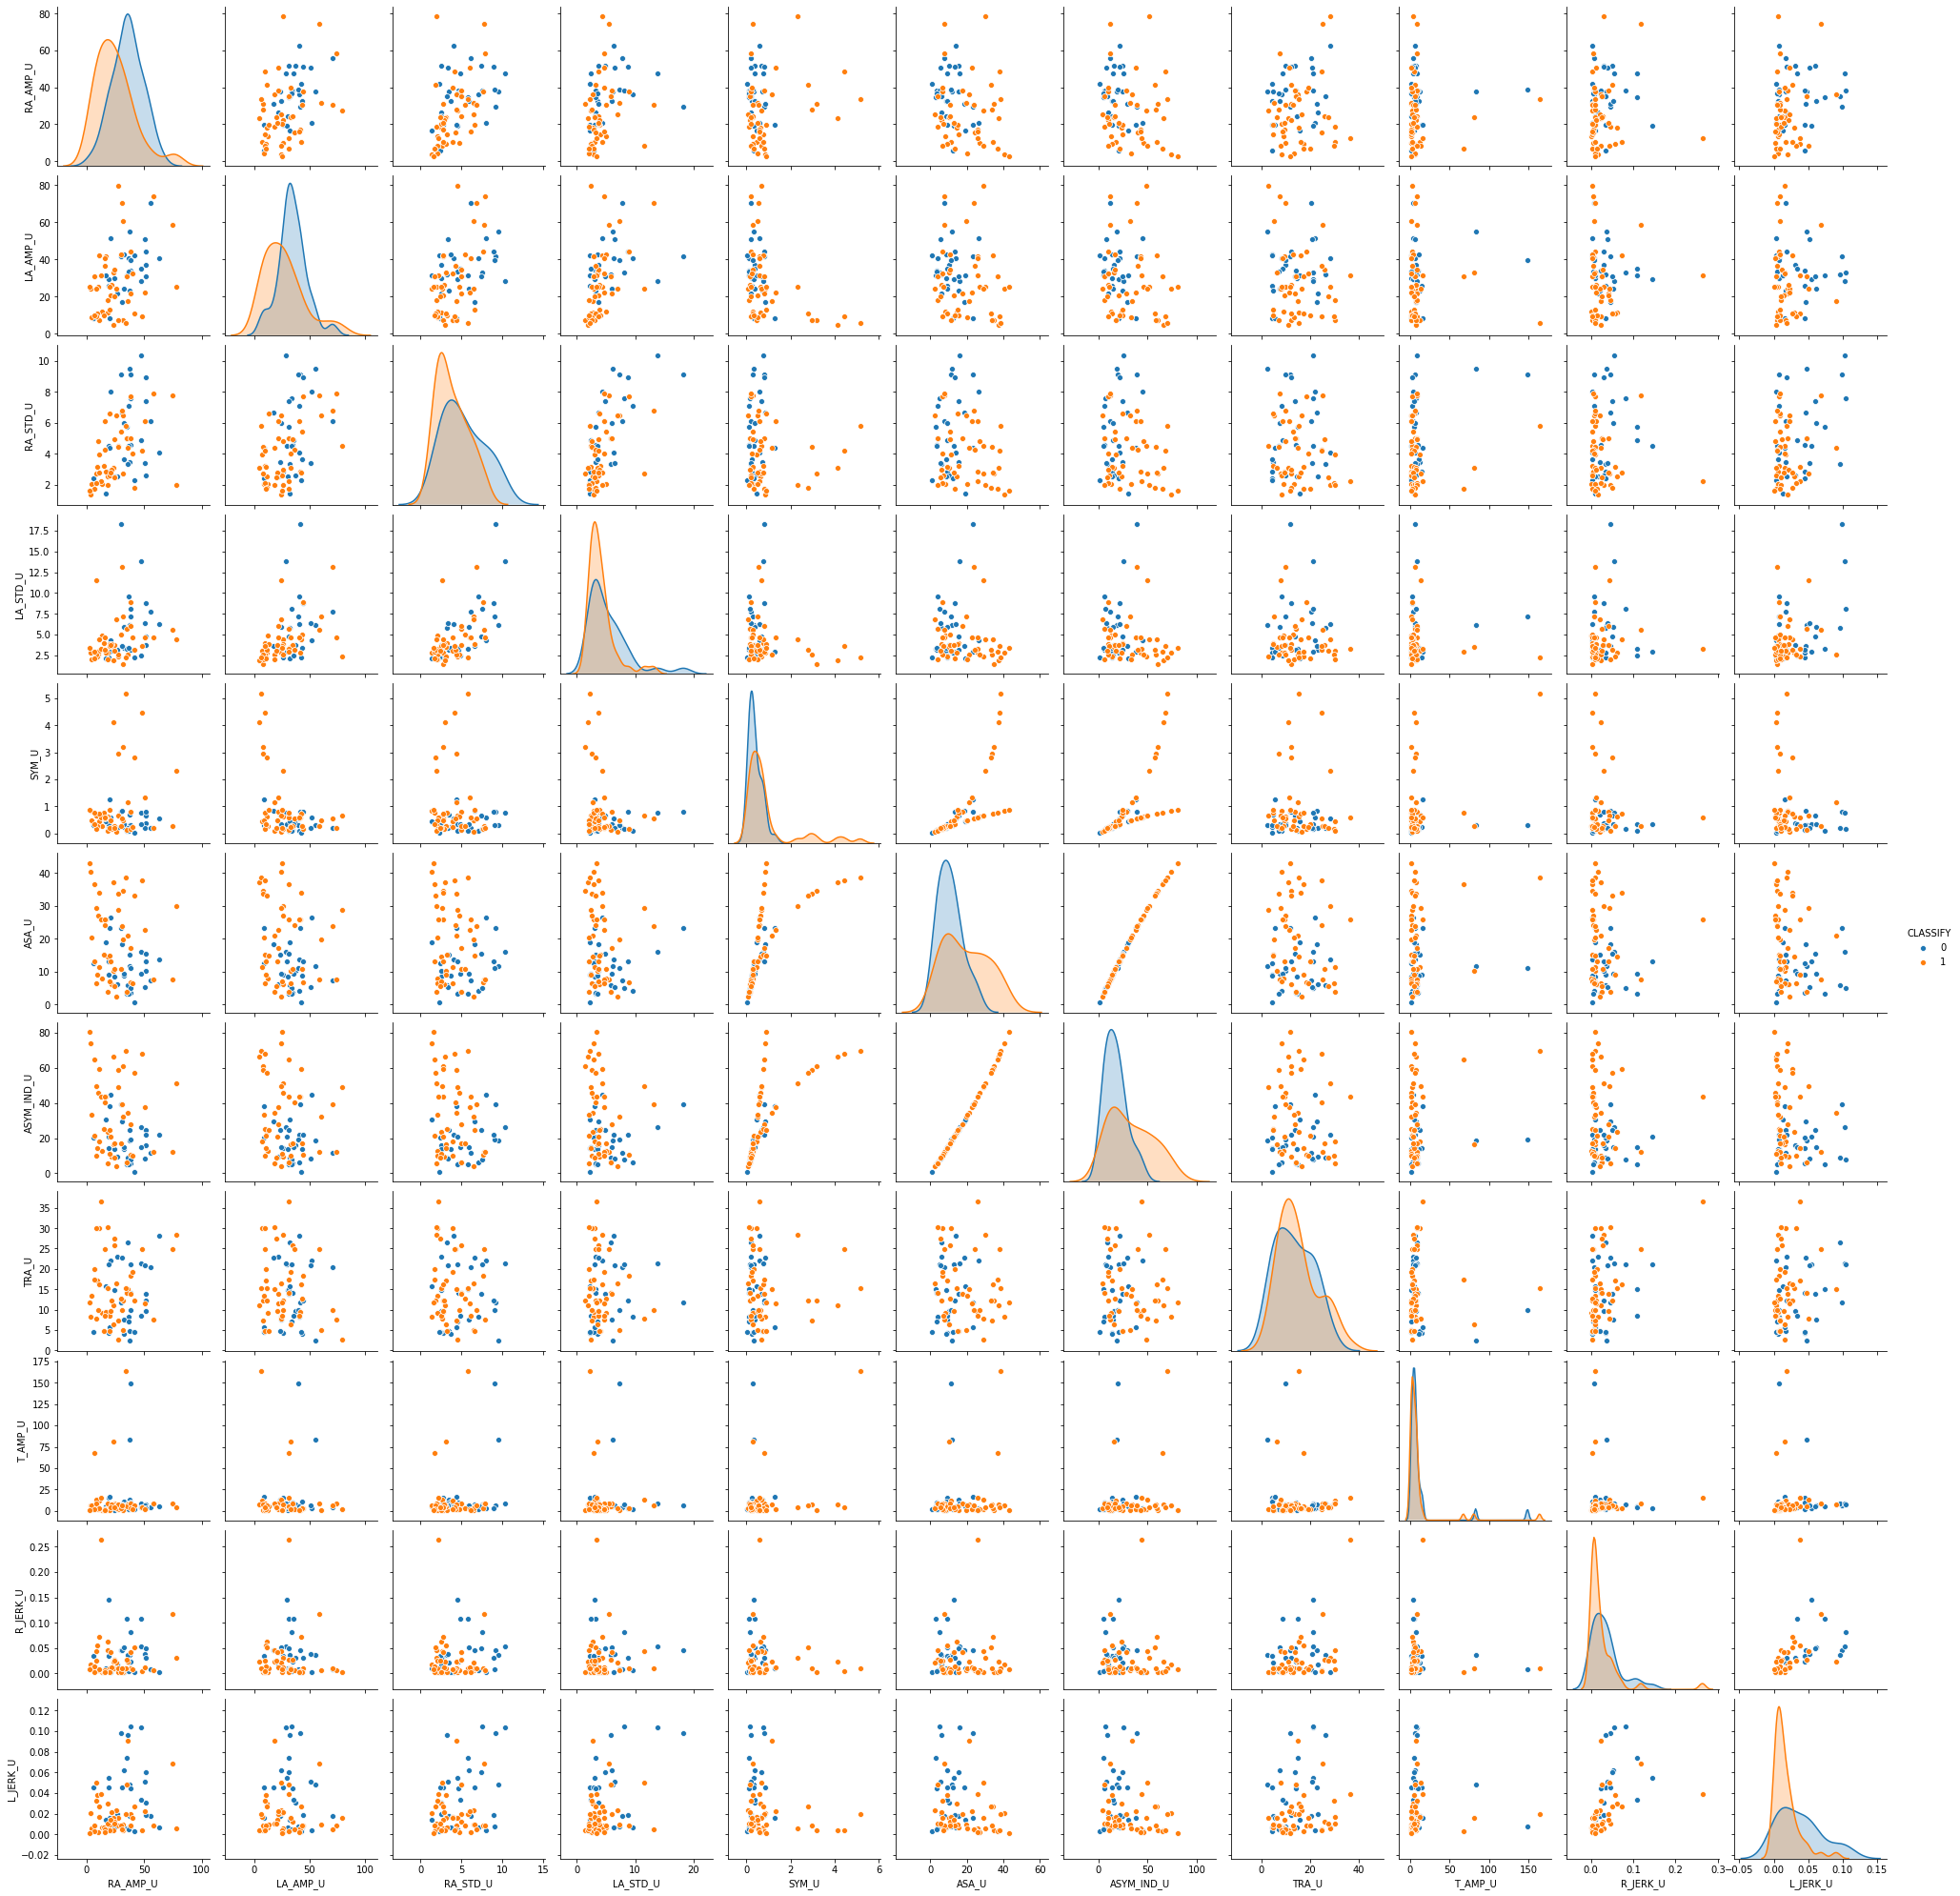

In [17]:
plt.figure(figsize=(10,10))
sns.pairplot(data2,vars=interest5,hue="CLASSIFY")




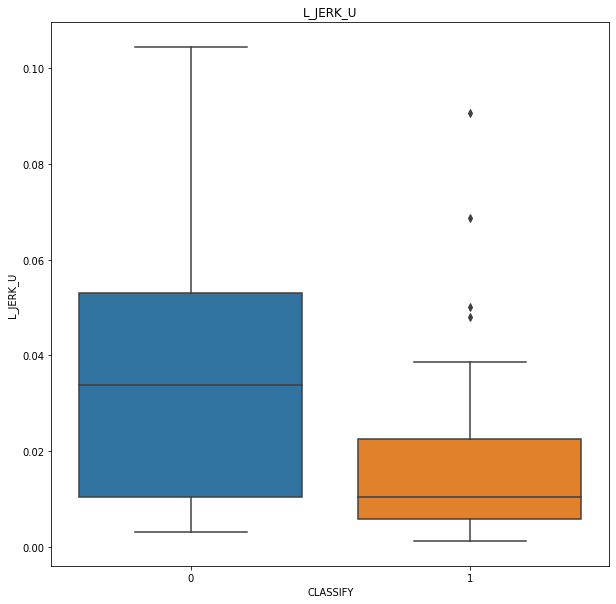

In [67]:
plt.figure(figsize = (10,10))
plt.title('L_JERK_U')
sns.boxplot(x = 'CLASSIFY',y = 'L_JERK_U',data = data2)

<Figure size 720x720 with 0 Axes>

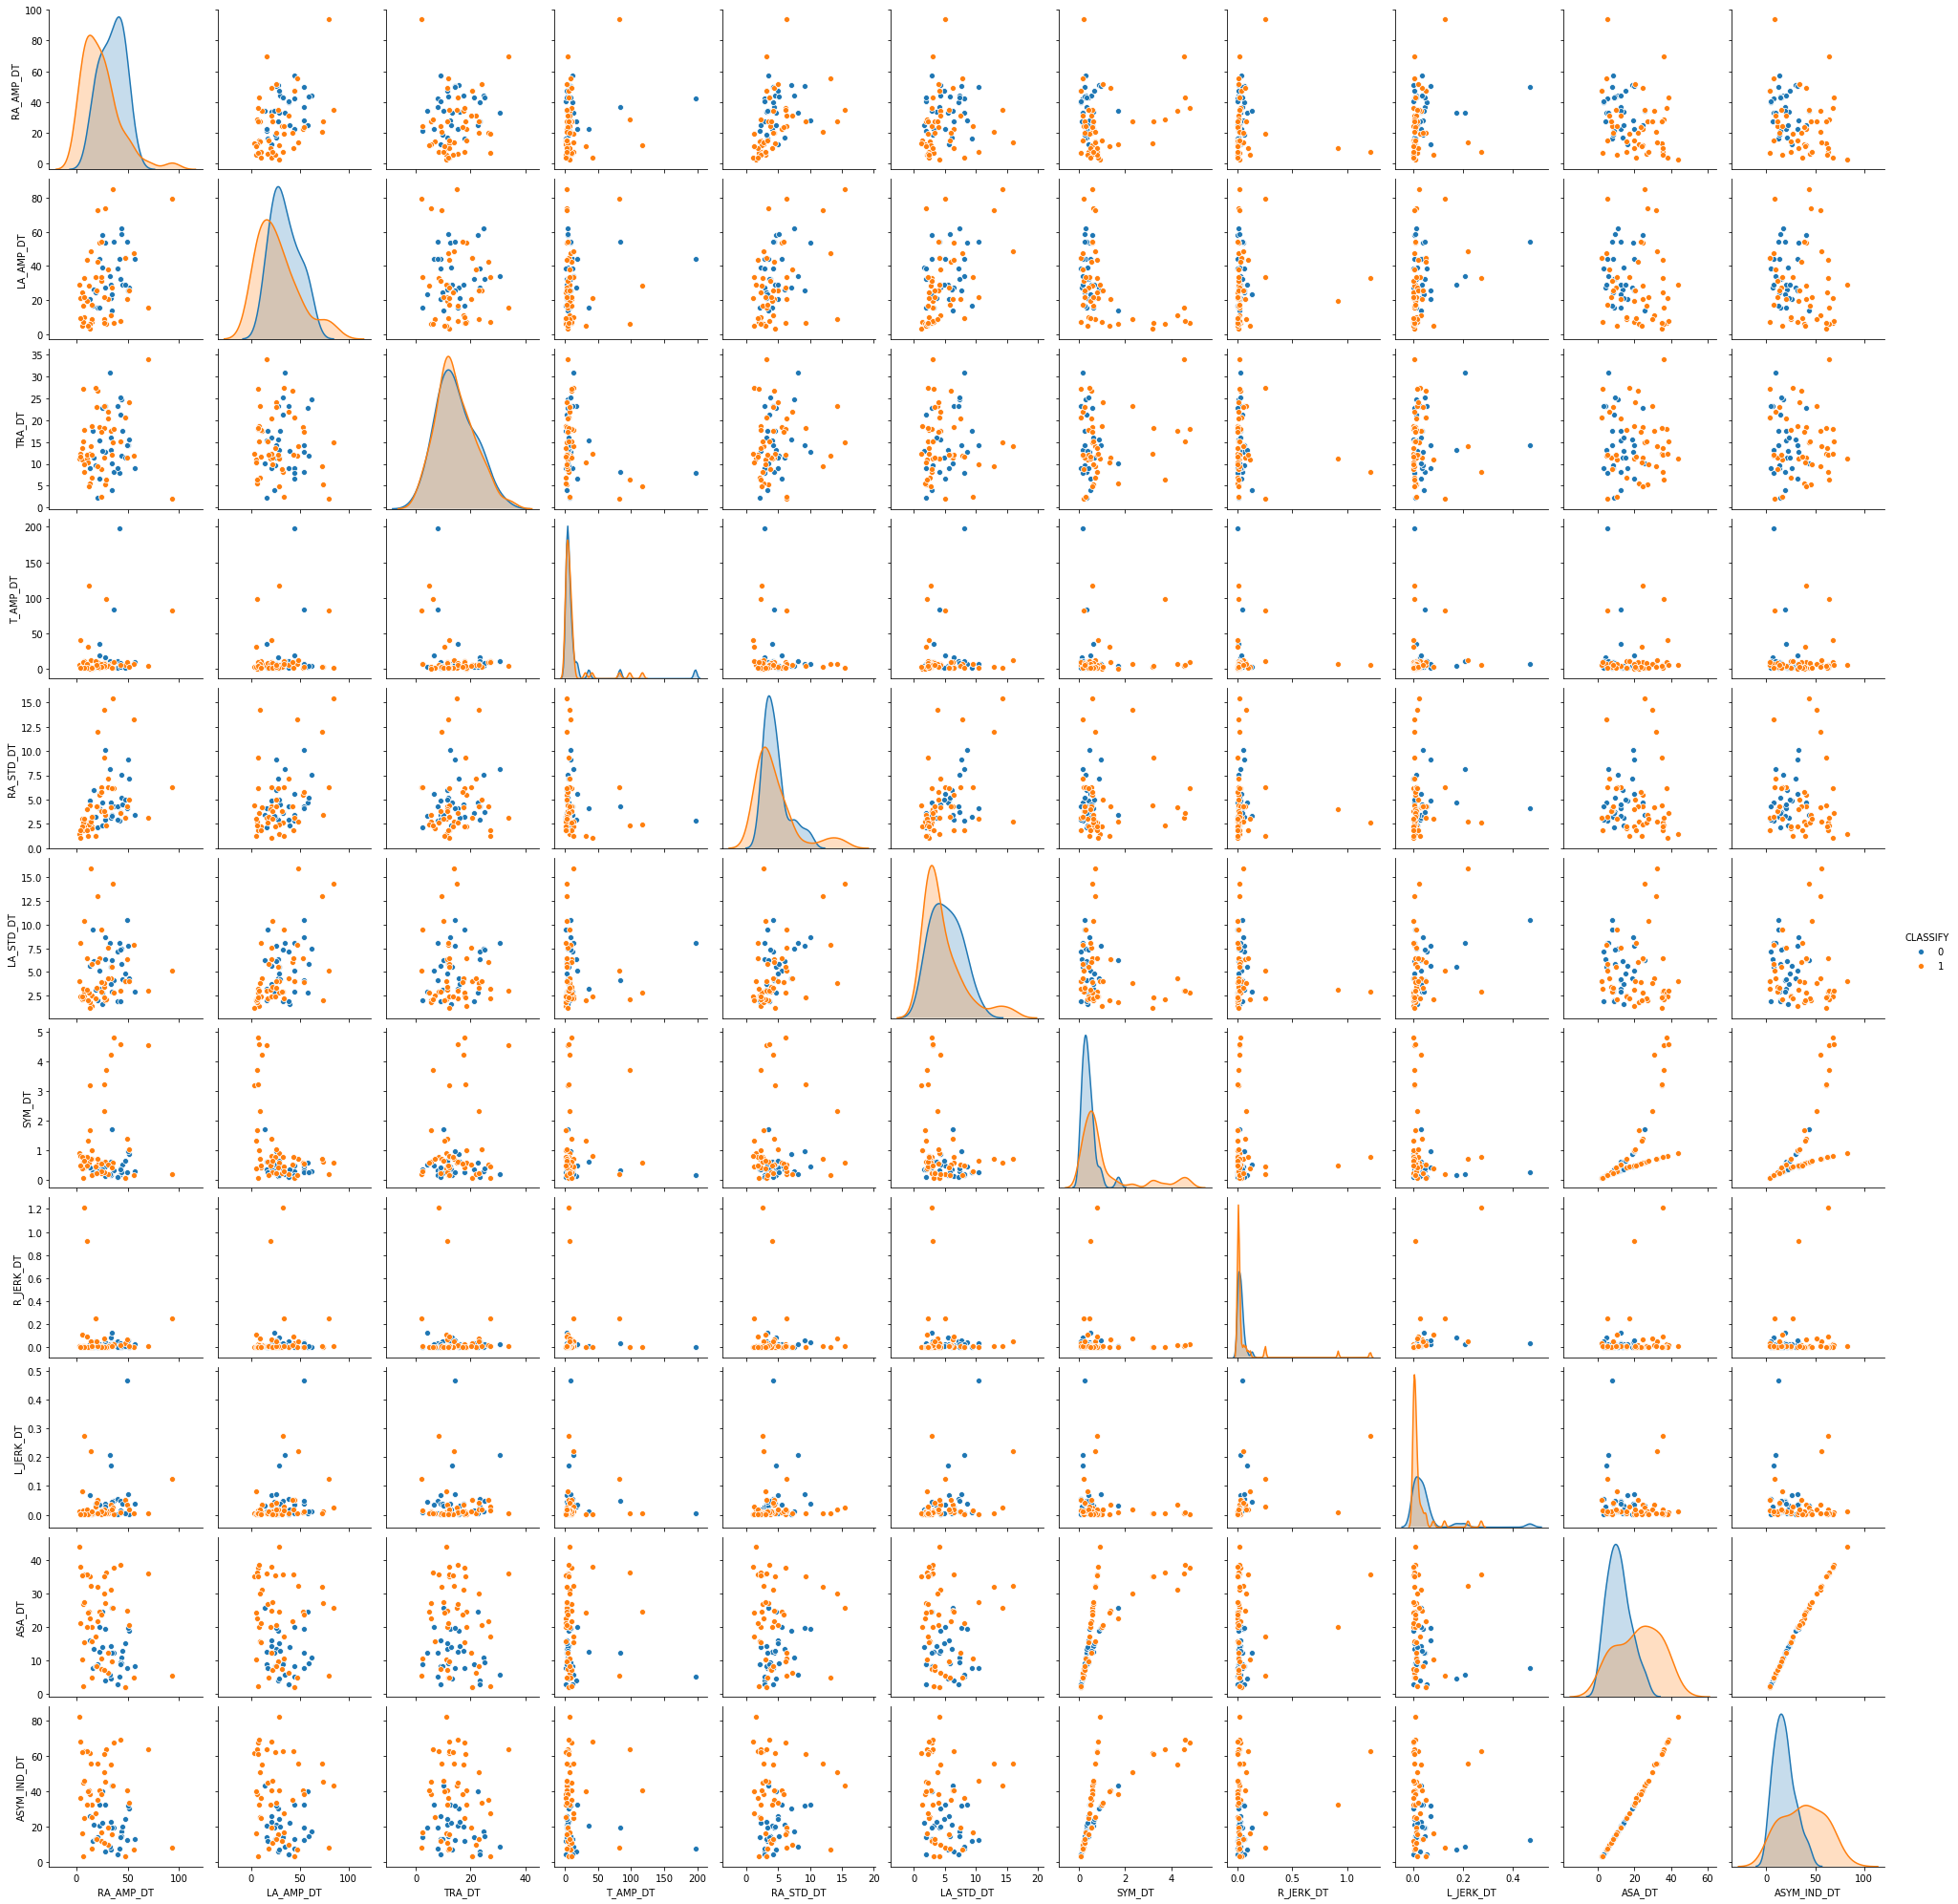

In [23]:
plt.figure(figsize=(10,10))
sns.pairplot(data2,vars=interest6,hue="CLASSIFY")

<Figure size 720x720 with 0 Axes>

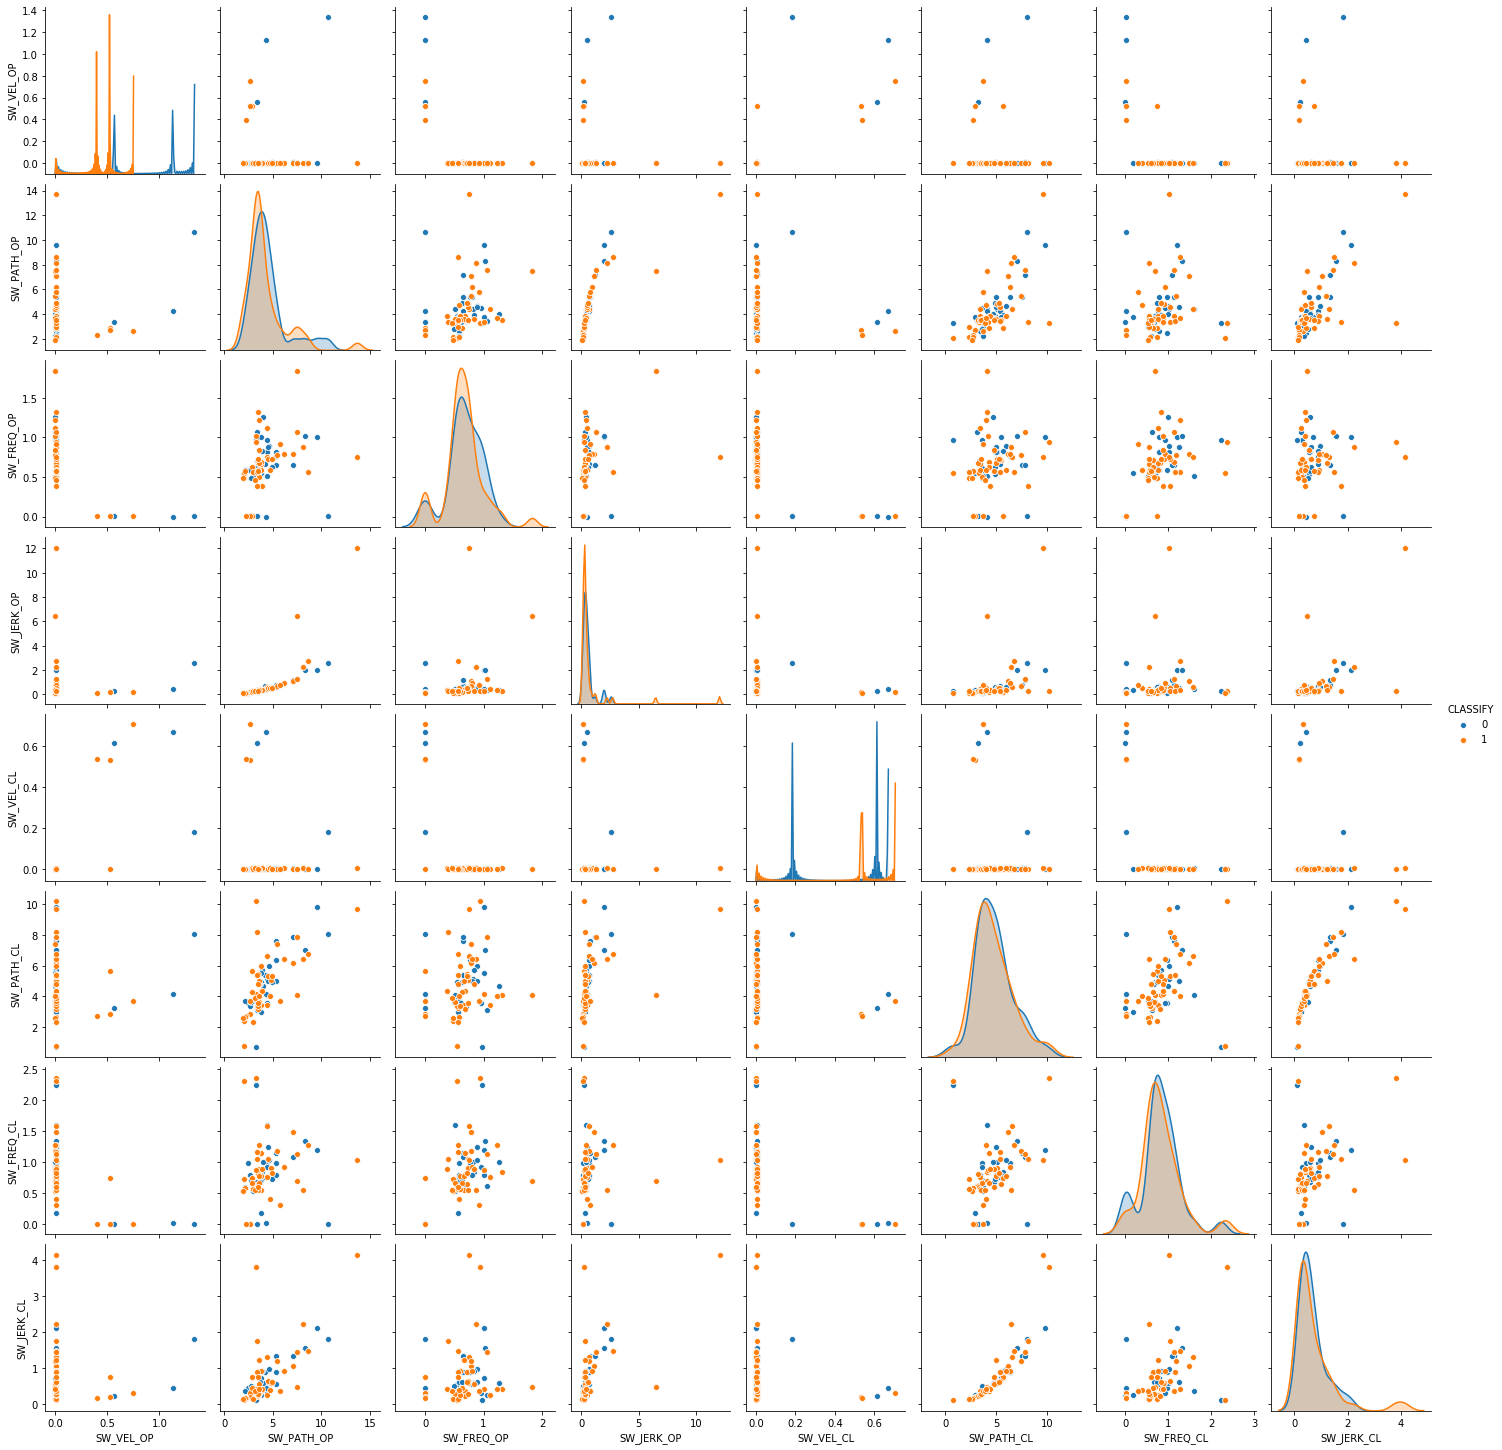

In [15]:
plt.figure(figsize=(10,10))
sns.pairplot(data2,vars=interest7,hue="CLASSIFY")

In [27]:
features=['SP_U', 'RA_AMP_U', 'LA_AMP_U', 'RA_STD_U',
       'LA_STD_U', 'SYM_U', 'R_JERK_U', 'L_JERK_U', 'ASA_U', 'ASYM_IND_U',
       'TRA_U', 'T_AMP_U', 'CAD_U', 'STR_T_U', 'STR_CV_U', 'STEP_REG_U',
       'STEP_SYM_U', 'JERK_T_U', 'SP_DT', 'RA_AMP_DT', 'LA_AMP_DT',
       'RA_STD_DT', 'LA_STD_DT', 'SYM_DT', 'R_JERK_DT', 'L_JERK_DT', 'ASA_DT',
       'ASYM_IND_DT', 'TRA_DT', 'T_AMP_DT', 'CAD_DT', 'STR_T_DT', 'STR_CV_DT',
       'STEP_REG_DT', 'STEP_SYM_DT', 'JERK_T_DT', 'SW_VEL_OP', 'SW_PATH_OP',
       'SW_FREQ_OP', 'SW_JERK_OP', 'SW_VEL_CL', 'SW_PATH_CL', 'SW_FREQ_CL',
       'SW_JERK_CL', 'TUG1_DUR', 'TUG1_STEP_NUM', 'TUG1_STRAIGHT_DUR',
       'TUG1_TURNS_DUR', 'TUG1_STEP_REG', 'TUG1_STEP_SYM', 'TUG2_DUR',
       'TUG2_STEP_NUM', 'TUG2_STRAIGHT_DUR', 'TUG2_TURNS_DUR', 'TUG2_STEP_REG',
       'TUG2_STEP_SYM']


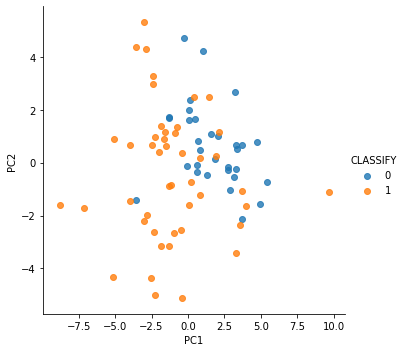

In [19]:
a=StandardScaler().fit_transform(data2[features])


pca=PCA(n_components=3)
X=pca.fit_transform(a)
y=data2.loc[:,'CLASSIFY'].values
pcadf=pd.DataFrame()
pcadf['PC1'] = X[:,0]
pcadf['PC2'] = X[:,1]
pcadf['PC3'] = X[:,2]
pcadf['CLASSIFY']=y

colors = {'1': 'red', '0': 'blue'}

sns.lmplot(x = 'PC1', y = 'PC2',data = pcadf, hue = 'CLASSIFY', fit_reg = False)

In [20]:
fig = px.scatter_3d(pcadf,x = 'PC1',y = 'PC2',z = 'PC3', color = 'CLASSIFY')
fig.show()

In [21]:
walk = ['SP','RA_AMP','LA_AMP','RA_STD','LA_STD','SYM','R_JERK','L_JERK','ASA','ASYM_IND','TRA'\
          ,'T_AMP','CAD','STR_T','STR_CV','STEP_REG','STEP_SYM','JERK_T']
sway = ['SW_VEL','SW_PATH','SW_FREQ','SW_JERK']

tug = ['DUR', 'STEP_NUM', 'STRAIGHT_DUR', 'TURNS_DUR',
       'STEP_REG', 'STEP_SYM']




In [22]:
walk = ['SP','RA_AMP','LA_AMP','RA_STD','LA_STD','SYM','R_JERK','L_JERK','ASA','ASYM_IND','TRA'\
          ,'T_AMP','CAD','STR_T','STR_CV','STEP_REG','STEP_SYM','JERK_T']
sway = ['SW_VEL','SW_PATH','SW_FREQ','SW_JERK']

tug = ['DUR', 'STEP_NUM', 'STRAIGHT_DUR', 'TURNS_DUR',
       'STEP_REG', 'STEP_SYM']

In [31]:
data2.rename(columns={'SP__DT':'SP_DT'},inplace=True)

D = pd.DataFrame()
D['PATNO'] = data2['PATNO']
for i in walk:
    u = str(i)+'_U'
    d = str(i)+'_DT'
    n = str(i)
    D[n] = data2[d] - data2[u]

for k in sway:
    o = str(k)+'_OP'
    c = str(k)+'_CL'
    m = str(k)
    D[m] = data2[o]-data2[c]

for l in tug:
    on = 'TUG1_'+str(l)
    tw = 'TUG2_'+str(l)
    t = str(l)
    D[t] = data2[tw] - data2[on]


D['CLASSIFY'] = data2['CLASSIFY']
D


PATNO     SP     RA_AMP     LA_AMP    RA_STD    LA_STD       SYM  \
0   40553 -0.006  -2.062411  -6.557989 -0.205953  1.647916  3.100361   
1   40555 -0.231  -0.957991   4.332993  0.137689  1.213421  0.055402   
2   40567 -0.050  -1.710586  12.214258  0.923899 -9.627348 -0.358770   
3   40578 -0.051  12.584862  13.849541 -1.887411 -1.654062 -0.066348   
4   40585 -0.160  10.473727  -1.012409 -0.695349  0.343296  0.571784   
..    ...    ...        ...        ...       ...       ...       ...   
72  42451 -0.197  -9.648098   2.319137  5.164581 -0.216988  0.145217   
73  42452 -0.735  -8.512911 -19.276563 -3.075267  5.663070  0.029168   
74  42453 -0.484   1.278285 -15.490988  0.230071  4.647145 -0.409498   
75  42456 -0.232  11.618315  -6.795610  0.992166 -0.614358  0.779088   
76  60118 -0.199  -4.066285   5.767093  1.800087  0.256084  0.029702   

      R_JERK    L_JERK        ASA  ...    JERK_T    SW_VEL   SW_PATH  \
0  -0.006709 -0.056528   9.948027  ... -0.044611  0.000160  0.385895   
1  -0.003237 -0.009578   3.460488  ... -0.072427  0.043489 -1.067492   
2   0.001545 -0.058640  -4.062851  ...  0.068292  0.000453 -1.112721   
3   0.010706  0.003767  -1.889023  ... -0.019652  0.000890  0.113968   
4   0.030007  0.015870   7.386693  ...  0.068063  0.521415 -2.788953   
..       ...       ...        ...  ...       ...       ...       ...   
72  0.004174  0.000435   8.192768  ... -0.090707 -0.000950 -0.696729   
73 -0.000593 -0.000576   1.533108  ... -0.296297  0.000094 -0.341738   
74 -0.006381 -0.000032 -22.055644  ... -0.091761 -0.000105 -0.399738   
75  0.001639  0.002932  14.083362  ...  0.046052 -0.000331  4.035335   
76  0.027468  0.031203   2.755561  ... -0.079984  0.000776 -1.281520   

     SW_FREQ   SW_JERK       DUR  STEP_NUM  STRAIGHT_DUR  TURNS_DUR  CLASSIFY  
0   0.118704  0.079843 -0.812500  0.464844     -0.015625  -0.574219         1  
1   0.000250 -0.154664 -0.898438 -0.406250      0.039062  -0.078125         1  
2  -0.390808 -0.301131 -0.695312 -1.714844     -0.015625  -0.039062         0  
3  -0.050788  0.023121 -0.148438  1.927734     -0.007812  -0.011719         1  
4  -0.735244 -0.559180  4.585938  7.638672     -0.023438   0.640625         1  
..       ...       ...       ...       ...           ...        ...       ...  
72 -0.082657 -0.116745 -0.625000 -0.379883     -0.015625  -0.078125         1  
73 -0.058753 -0.188180 -2.750000 -2.412109     -0.093750  -0.164062         1  
74 -0.047427 -0.053441 -0.148438 -0.395508      0.078125   1.144531         1  
75 -0.277961  7.920828 -0.632812  1.621094     -0.062500  -0.093750         1  
76 -0.025215 -0.469969 -0.460938  0.553711     -0.015625   0.035156         1  

[77 rows x 28 columns]

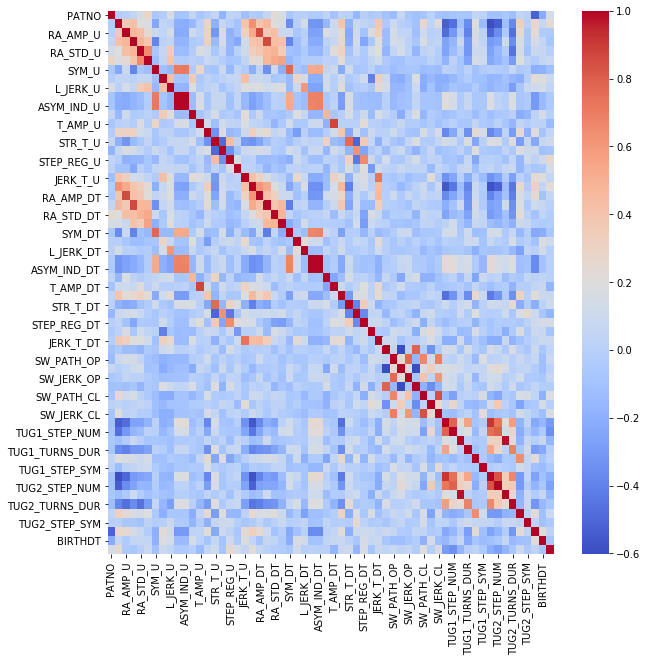

In [34]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),cmap='coolwarm' )

Once you have your labelled data (identifying each subject as having PD or no PD) you can now start thinking about building an ML algorithm to predict the diagnosis based on the gait data. The basic idea is that you wait train your algorithm on a portion of the data and then see how well it predicts a dignosis of PD on the out-of-sample (i.e., "test") data. A good first classification algorithm to learn and use is **logistic regression.** 

But before you learn about logistic regression, you should probably learn the ins and outs of linear regression. For that, and all other things ML, I highly recommend "Introduction to Statistical Learning" by James, Witten, Hastie and Tibshirani.  